## Laboratory 4 homework

Homework is creating a multimodal similarity search service. It will retrieve
images based on a text query, using embeddings from a multimodal model.

### Dataset preparation (1 point)

1. Download the dataset: [Amazon Berkeley Objects
   Dataset](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar)
2. Unpack the dataset and locate the metadata file `images.csv.gz` in
   `images/metadata/`
3. Extract the image paths from the dataset:
   - write a Python script that extracts valid image paths from the CSV file
   - keep only images with at least 1000 pixels of width and height
   - you can use Pandas, Polars etc. as you wish, add with `uv` whatever is
     necessary

In [ ]:
import os
import polars as pl

image_paths = (
    pl.scan_csv("images/metadata/images.csv.gz")
    .with_columns(pl.col("path").map_elements(lambda p: os.path.join("images", "small", p)).alias("path"))
    .filter(
        pl.col("height") >= 1000,
        pl.col("width") >= 1000,
        pl.col("path").map_elements(os.path.exists, return_dtype=pl.Boolean),
    )
    .select(pl.col("path"))
    .collect()
    .to_series()
)
image_paths

path
str
"""images/small/46/4689906d.png"""
"""images/small/0c/0cd7596c.jpg"""
"""images/small/e6/e602a9af.jpg"""
"""images/small/e7/e7cfeb02.jpg"""
"""images/small/68/6839db4e.jpg"""
…
"""images/small/6d/6d49d130.jpg"""
"""images/small/b1/b163e0ea.jpg"""
"""images/small/a1/a116d9d1.jpg"""


### Model Selection and Understanding (1 point)

1. Read the [CLIP Image Search
   Tutorial](https://www.sbert.net/examples/applications/image-search/README.html).
2. Search for `clip-ViT-B-32` model from `sentence-transformers` on HuggingFace
   Hub.
3. Determine the vector length (size) produced by the model, and what type of
   model is it.

**Questions:**
- What is the vector size produced by `clip-ViT-B-32`?

  Based on the CLIP paper (Table 20.) the embedding size is **512**.

- What do `ViT`, `B` and `32` mean in the model name?

  ViT = Vision Transformer = Transformer architecture for images
  B = Base = Smaller of the two proposed size (B and L)
  32 = Patch size = Image is cut into 32x32 square patches that are fed to the ViT as tokens


### Database setup (2 points)

1. Set up Postgres database with `pgvectorscale` extension. You can reuse the
   database from the lab.
2. Use SQLAlchemy to connect to it with `create_engine` and `URL`.
3. Create a database table definition for storing image embeddings. Complete the
   following SQLAlchemy model:

In [2]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, text

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db",
)

engine = create_engine(db_url)

with engine.connect() as conn:
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS vector;"))
    conn.commit()

In [3]:
from typing import List
from pgvector.sqlalchemy import Vector
from sqlalchemy import String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column


# Create the base class for the table definition
class Base(DeclarativeBase):
    __abstract__ = True


# Create the table definition
class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))


# Create table
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

## Image vectorization (3 points)

Fill the code below that performs image vectorization, i.e. calculates an
embedding for each image. Model input is an image, its output is a vector
(embedding).

Notes:
1. Adjust `MAX_IMAGES`, the number of images processed, based on your
   computational capabilities. The more images you process, the more accureate
   results of search you will get. If you have a GPU, you can use it and process
   more images.
2. Load the CLIP model with `sentence-transformers`. It is a nice, high-level
   framework, based on PyTorch. To enable GPU usage, the following code is
   useful:

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device.upper()}")

Using device: CUDA


3. Implement
   [batching](https://docs.python.org/3/library/itertools.html#itertools.batched)
   for efficiency, as embedding a single image at a time is very inefficient. In
   that case, you would spend most of the time sending data between RAM and
   CPU/GPU, instead of actually doing the work. Working in batches optimizes
   this transfer time. Similarly, batching is more efficient for databases, as
   it lowers the overhead for managing transactions.
4. Implement all necessary code parts:
   - iterate through image paths
   - implement batching
   - insert batch of images into the database
   - update progress bar `pgar` with appropriate batch size

In [ ]:
import joblib
import sqlalchemy

from itertools import batched
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session

MAX_IMAGES = 25_000  # Adjust it for your needs
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

# Load CLIP model
model = SentenceTransformer("clip-ViT-B-32", device=device)


def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine: sqlalchemy.Engine, model: SentenceTransformer, image_paths):
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths, BATCH_SIZE):  # finish (suggestion - use `batched`)
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            images = [Img(image_path=path, embedding=emb) for path, emb in zip(images_paths_batch, embeddings)]

            # insert all batch images
            insert_images(engine, images)

            # update pbar
            pbar.update(len(images))

### Search and results display (3 points)

Fill the code below that searches for the most similar embeddings based on a
text description. After that:
1. Check a few different queries. Are results relevant?
2. Check 3 different MAX_IMAGES sizes. Do you see more accurate results for
   larger datasets?

In [23]:
import matplotlib.pyplot as plt
from sqlalchemy import select


class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images([img.image_path for img in found_images], k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description)

        with Session(self.engine) as session:
            query = select(Img).order_by(Img.embedding.cosine_distance(image_embedding)).limit(k)
            result = session.execute(query, execution_options={"prebuffer_rows": True})

        return result.scalars().all()

    def display_images(self, images, k: int):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

  0%|          | 0/25000 [00:00<?, ?it/s]

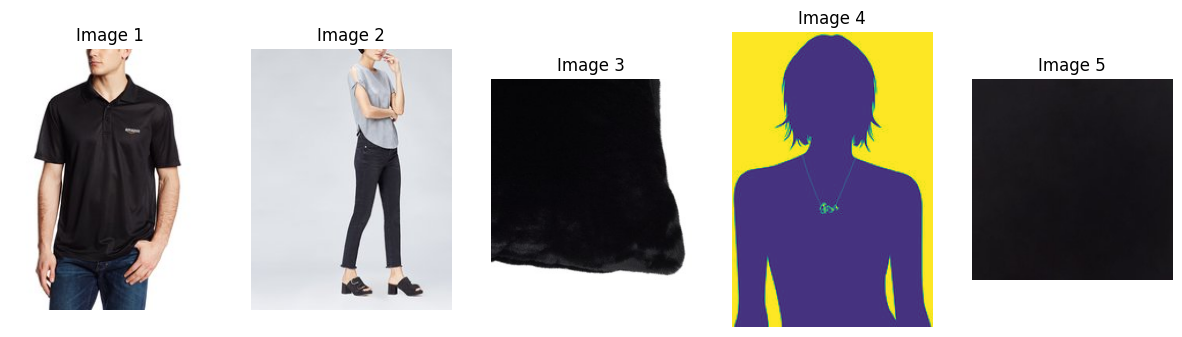

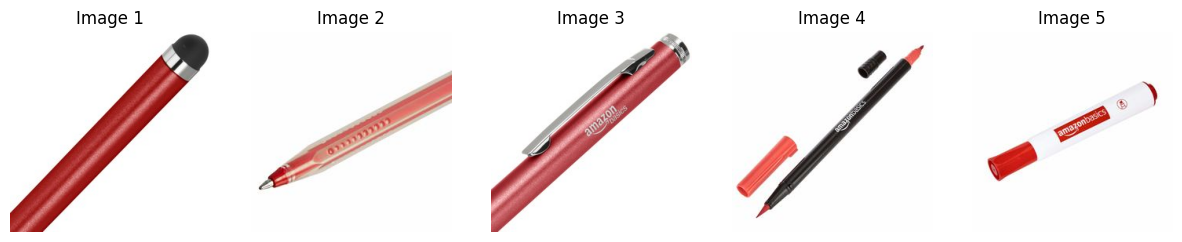

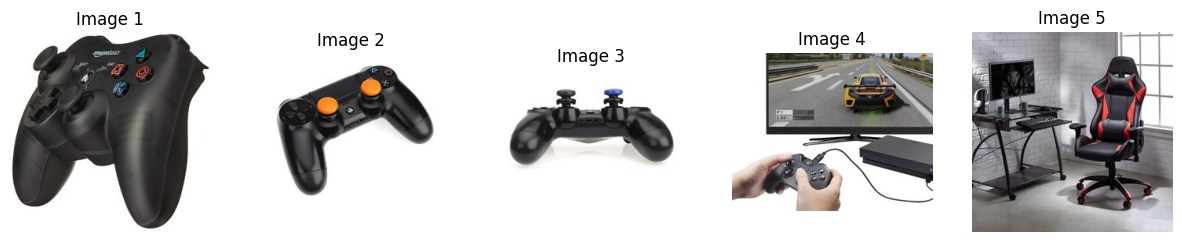

In [24]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
MAX_IMAGES = 25_000
vectorize_images(engine, model, image_paths.sample(MAX_IMAGES))

ImageSearch(engine, model)("black t-shirt", k=5)
ImageSearch(engine, model)("red pencil", k=5)
ImageSearch(engine, model)("gaming", k=5)

  0%|          | 0/50000 [00:00<?, ?it/s]

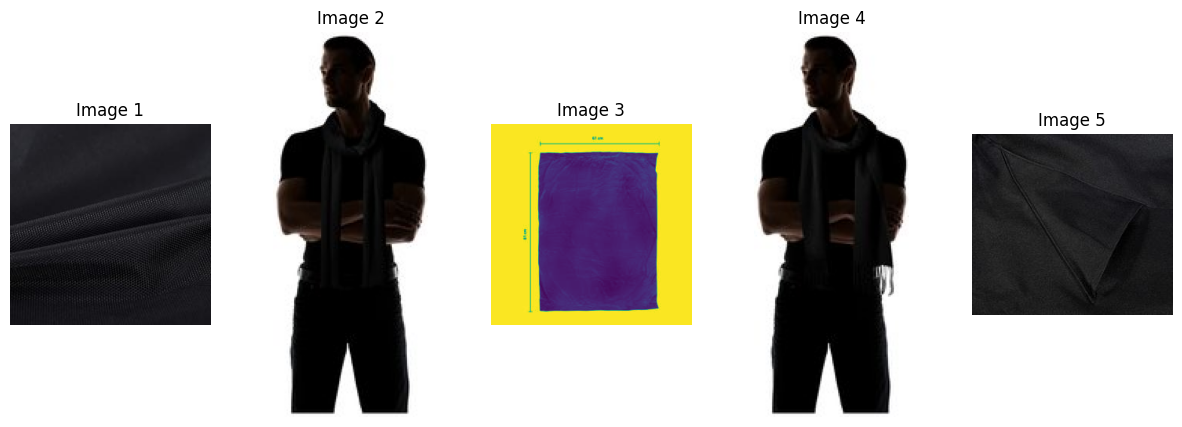

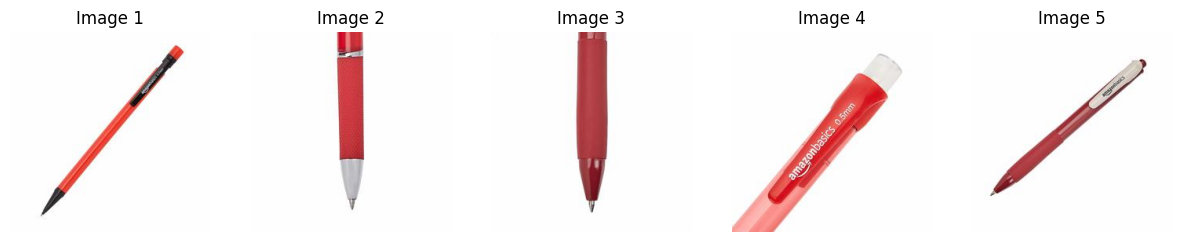

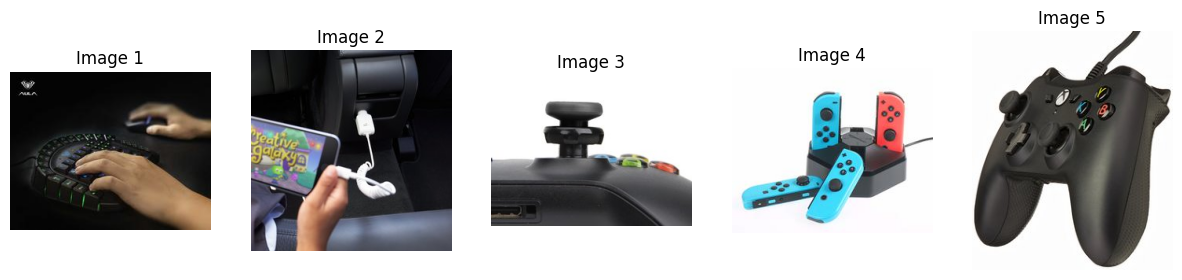

In [25]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
MAX_IMAGES = 50_000
vectorize_images(engine, model, image_paths.sample(MAX_IMAGES))

ImageSearch(engine, model)("black t-shirt", k=5)
ImageSearch(engine, model)("red pencil", k=5)
ImageSearch(engine, model)("gaming", k=5)

  0%|          | 0/100000 [00:00<?, ?it/s]

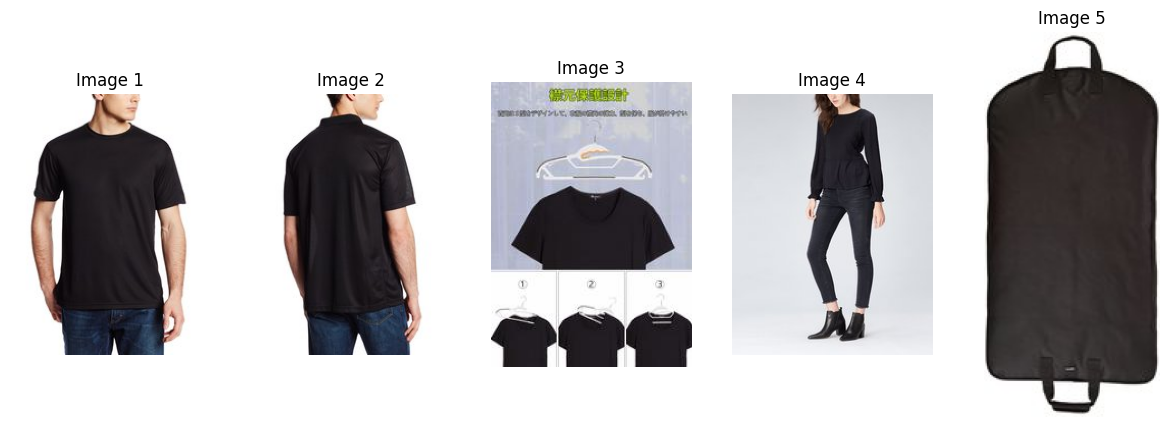

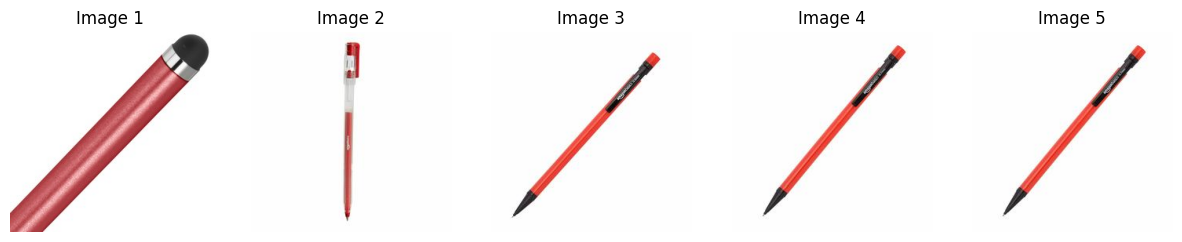

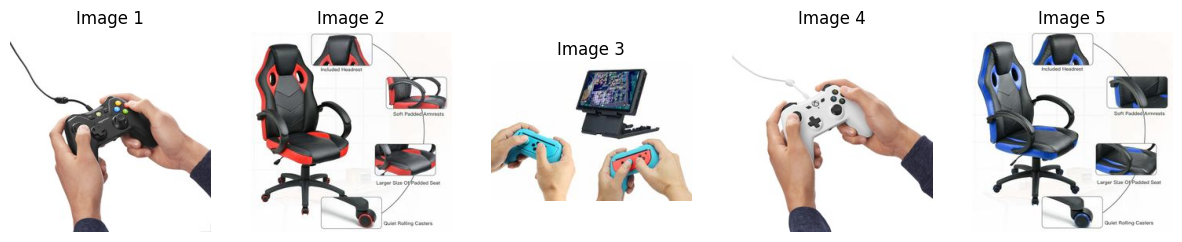

In [26]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
MAX_IMAGES = 100_000
vectorize_images(engine, model, image_paths.sample(MAX_IMAGES))

ImageSearch(engine, model)("black t-shirt", k=5)
ImageSearch(engine, model)("red pencil", k=5)
ImageSearch(engine, model)("gaming", k=5)